# Walmart : Sales in Stormy Weather

<img src="data/walmart.jpg">

# [ Overview ]

### (1) Objective : 
> #### 20 지역에서 관측한 날씨에 따른, 월마트 매장 45곳에서 판매하는 111가지 품목의 판매량( `units` )을 예측한다.

### (2) Data : 
> #### train : 4617600 rows, 4 columns  
> - 2012년 1월 1일 ~ 2014년 10월 31일 사이 월마트 매장 45곳에서 판매하는 111가지 품목의 판매량 데이터  

> #### key : 45 rows, 2 columns
> - 20 지역의 관측소와, 같은 지역에 위치한 월마트 매장 45곳을 레이블링한 표  

> #### weather : 20517 rows, 20 columns
> - 2012년 1월 1일 ~ 2014년 10월 31일 사이 20지역의 날씨 데이터  
> - 온도 : Fahrenheit
- 풍속 : mph
- `snowfall`, `preciptotal` : inch  
- M : Missing 
- T : Trace ( 땅이 젖었 때 )  

>- **Weather Data 각 Columns의 정의**
    - date : 날짜
    - tmax : 최대 온도
    - tmin : 최저 온도
    - depart : 과거 30년 동안의 최대온도의 평균과 `tmax`값의 차
    - dewpoint : 평균 이슬점
    - wetbulb : 평균 습도
    - heat : 난방 지수 (65 - `avg`) 1 ~ 6월 적용
    - cool : 냉방 지수 (`tavg` - 65) 7 ~ 12월 적용
    - sunrise : 일출 시간
    - sunset : 일몰 시간 
    - codesum : 특이 날씨 코드
        - +FC : TORNADO/WATERSPOUT
        - FC : FUNNEL CLOUD
        - TS : THUNDERSTORM
        - GR : HAIL
        - RA : RAIN
        - DZ : DRIZZLE
        - SN : SNOW
        - SG : SNOW GRAINS
        - GS : SMALL HAIL &/OR SNOW PELLETS
        - PL : ICE PELLETS
        - IC : ICE CRYSTALS
        - FG+: HEAVY FOG (FG & LE.25 MILES VISIBILITY)
        - FG : FOG
        - BR : MIST
        - UP : UNKNOWN PRECIPITATION
        - HZ : HAZE
        - FU : SMOKE
        - VA : VOLCANIC ASH
        - DU : WIDESPREAD DUST
        - DS : DUSTSTORM
        - PO : SAND/DUST WHIRLS
        - SA : SAND
        - SS : SANDSTORM
        - PY : SPRAY
        - SQ : SQUALL
        - DR : LOW DRIFTING
        - SH : SHOWER
        - FZ : FREEZING
        - MI : SHALLOW
        - PR : PARTIAL
        - BC : PATCHES
        - BL : BLOWING
        - VC : VICINITY
        - (-) : LIGHT
        - (+) : HEAVY
        - 표기가 안 되어 있다면 : moderate weather
    - snowfall : 눈이 쌓인 정도 (inches)
    - precipitotal : 24시간 기준 강수량 (inches)
    - stnpressure : 평균 기압
    - sealevel : 해수면 압력
    - resultspeed : 합성 풍속 (mph)
    - resultdir : 합성 풍향 (10도씩) 
    - avgspeed : 평균 풍속 (mph)

        
> #### test : 526917 rows, 3 columns
> - 2013년 4월 1일 ~ 2014년 10월 26일 사이 월마트 매장 44곳 (35번 매장 누락) 에 대한 템플릿 

### (3) : Evaluation
> #### 예측값과 실제값의 차이를 Root-Mean-Squared-Logarithmic-Error(RMSLE)로 채점한다.

## [ Load Data ]

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd

### train

In [2]:
train = pd.read_csv("data/train.csv")
print(train.shape)
train.head()

(4617600, 4)


,date,store_nbr,item_nbr,units
0,2012-01-01,1,1,0
1,2012-01-01,1,2,0
2,2012-01-01,1,3,0
3,2012-01-01,1,4,0
4,2012-01-01,1,5,0


### keys

In [3]:
keys = pd.read_csv("data/key.csv")
print(keys.shape)
keys.head()

(45, 2)


,store_nbr,station_nbr
0,1,1
1,2,14
2,3,7
3,4,9
4,5,12


### weather

In [4]:
weather_1 = pd.read_csv("data/weather.csv")

# input data in order to reflect [ "NO SIGN" : MODERATE ] in description
def codesum_moderate(codesum):
    if codesum == " ":
        return "moderate"
    else:
        return codesum
        
weather_1['codesum'] = weather_1['codesum'].apply(codesum_moderate)

print(weather_1.shape)
weather_1.head()

(20517, 20)


,station_nbr,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,sunrise,sunset,codesum,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed
0,1,2012-01-01,52,31,42,M,36,40,23,0,-,-,RA FZFG BR,M,0.05,29.78,29.92,3.6,20,4.6
1,2,2012-01-01,48,33,41,16,37,39,24,0,0716,1626,RA,0.0,0.07,28.82,29.91,9.1,23,11.3
2,3,2012-01-01,55,34,45,9,24,36,20,0,0735,1720,moderate,0.0,0.00,29.77,30.47,9.9,31,10.0
3,4,2012-01-01,63,47,55,4,28,43,10,0,0728,1742,moderate,0.0,0.00,29.79,30.48,8.0,35,8.2
4,6,2012-01-01,63,34,49,0,31,43,16,0,0727,1742,moderate,0.0,0.00,29.95,30.47,14.0,36,13.8


### Merge train & weather by keys

In [5]:
train_key = pd.merge(keys, train)
df_1 = pd.merge(weather_1, train_key)

print(df_1.shape)
df_1.head()

(4617600, 23)


,station_nbr,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,...,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,store_nbr,item_nbr,units
0,1,2012-01-01,52,31,42,M,36,40,23,0,...,M,0.05,29.78,29.92,3.6,20,4.6,1,1,0
1,1,2012-01-01,52,31,42,M,36,40,23,0,...,M,0.05,29.78,29.92,3.6,20,4.6,1,2,0
2,1,2012-01-01,52,31,42,M,36,40,23,0,...,M,0.05,29.78,29.92,3.6,20,4.6,1,3,0
3,1,2012-01-01,52,31,42,M,36,40,23,0,...,M,0.05,29.78,29.92,3.6,20,4.6,1,4,0
4,1,2012-01-01,52,31,42,M,36,40,23,0,...,M,0.05,29.78,29.92,3.6,20,4.6,1,5,0


-------------------------

# 1. EDA


In [6]:
import scipy as sp
import matplotlib as mpl
import matplotlib.pylab as plt
import seaborn as sns
sns.set()
sns.set_style("whitegrid")

df_tmp = df_1.copy()

## 1. 1. Check tendency

### 1. 1. 1.  `year` , `store_nbr` vs `units`

In [7]:
def show_tendency(store_number):
    '''
    input : store_nbr
    output : graph represetning total units for each year, each month
    '''
    
    # split year, month     
    def make_year(date):
        return int(date.split('-')[0])
    def make_month(date):
        return int(date.split('-')[1])
    df_tmp['year'] = df_tmp['date'].apply(make_year)
    df_tmp['month'] = df_tmp['date'].apply(make_month)
    
    
    # show yearly units tendency by store_nbr
    store_month = df_tmp.pivot_table(index=['year','month'],columns='store_nbr',values='units',aggfunc=np.sum)
    
    target_store = store_month[store_number]
    that_2012 = target_store.loc[2012]
    that_2013 = target_store.loc[2013]
    that_2014 = target_store.loc[2014]
    
    plt.figure(figsize=(12,8))
    plt.plot(that_2012,label='2012',c='blue',ls='--',lw=4)
    plt.plot(that_2013,label='2013',c='green',ls=':',marker='D',ms=10,lw=4)
    plt.plot(that_2014,label='2014',c='red',lw=4)
    plt.legend(loc='best',prop={'size':20})
    plt.show()

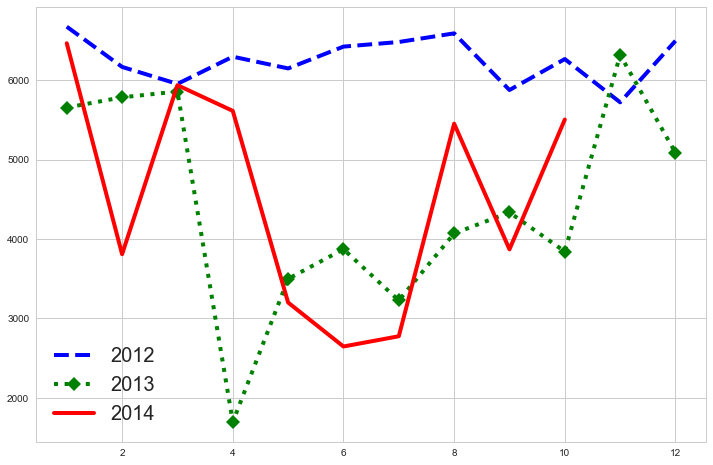

In [8]:
show_tendency(2)

### 1. 1. 2.  `year`, `month`, `store_nbr` vs `units`

In [9]:
def item_nbr_tendency(store_nbr):
    '''
    input : store_nbr
    output : graph representing units groupped by each year, each month
    '''
    store = df_tmp[df_tmp['store_nbr'] == store_nbr]

    pivot = store.pivot_table(index=['year','month'],columns='item_nbr',values='units',aggfunc=np.sum)
    zero_index = pivot==0
    pivot = pivot[pivot!=0].dropna(axis=1,how='all')
    pivot[zero_index]=0
    
    
    pivot_2012 = pivot.loc[2012]
    pivot_2013 = pivot.loc[2013]
    pivot_2014 = pivot.loc[2014]
    
    plt.figure(figsize=(12,8))
    plt.subplot(131)
    sns.heatmap(pivot_2012,cmap="YlGnBu", annot = True, fmt = '.0f')
    plt.subplot(132)
    sns.heatmap(pivot_2013,cmap="YlGnBu", annot = True, fmt = '.0f')
    plt.subplot(133)
    sns.heatmap(pivot_2014,cmap="YlGnBu", annot = True, fmt = '.0f')
    plt.show()

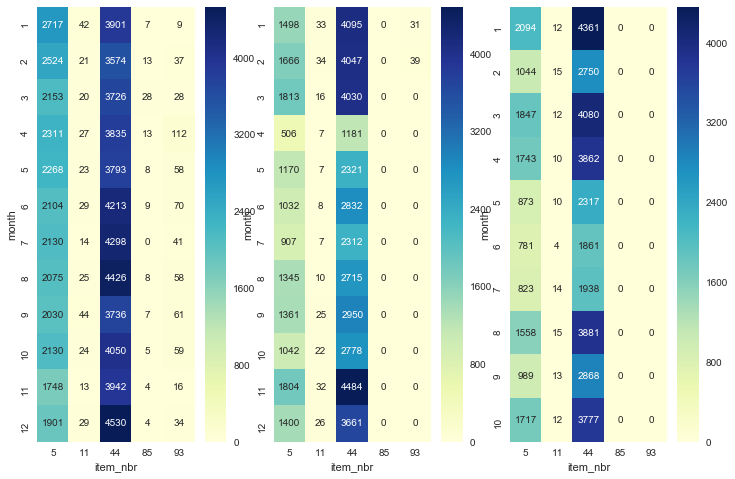

In [10]:
item_nbr_tendency(2)

### 1. 1. 3.  `year`, `month`, `day`, `store_nbr`, `item_nbr` vs `units`

In [11]:
def item_nbr_tendency_finely(store_nbr, year, month_start=-1, month_end=-1, graph=True):
    '''
    input
        1. store_nbr = 스토어 번호
        2. year = 연도
        3. month_start = 시작달
        4. month_start = 끝달
        5. graph = 위의 정보에 대한 item_nbr 그래프 출력여부
    
    output
        1. store_nbr, year, month로 filtering한 item_nbr의 pivot 테이블
    '''
    store = df_tmp[(df_tmp['store_nbr'] == store_nbr) & (df_tmp['year'] == year)]

    if month_start != -1:
        if month_end == -1:
            month_end = month_start + 1
        store = store[(month_start <= store['month']) & (store['month'] < month_end)]

    pivot = store.pivot_table(index='item_nbr',
                              columns='date',
                              values='units',
                              aggfunc=np.sum)

    zero_index = pivot == 0
    pivot = pivot[pivot != 0].dropna(axis=0, how='all')
    pivot[zero_index] = 0

    if graph:
        plt.figure(figsize=(12, 8))
        sns.heatmap(pivot, cmap="YlGnBu", annot=True, fmt='.0f')
        plt.show()

    return pivot

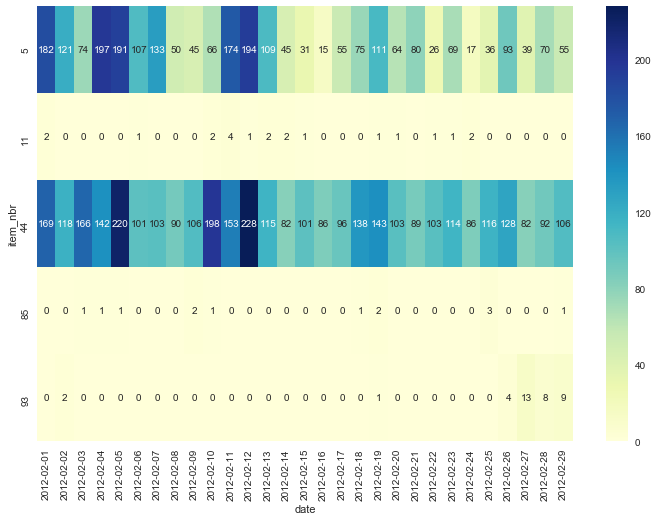

date,2012-02-01,2012-02-02,2012-02-03,2012-02-04,2012-02-05,2012-02-06,2012-02-07,2012-02-08,2012-02-09,2012-02-10,...,2012-02-20,2012-02-21,2012-02-22,2012-02-23,2012-02-24,2012-02-25,2012-02-26,2012-02-27,2012-02-28,2012-02-29
item_nbr,,,,,,,,,,,,,,,,,,,,,
5,182.0,121.0,74.0,197.0,191.0,107.0,133.0,50.0,45.0,66.0,...,64.0,80.0,26.0,69.0,17.0,36.0,93.0,39.0,70.0,55.0
11,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,...,1.0,0.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0
44,169.0,118.0,166.0,142.0,220.0,101.0,103.0,90.0,106.0,198.0,...,103.0,89.0,103.0,114.0,86.0,116.0,128.0,82.0,92.0,106.0
85,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0
93,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,13.0,8.0,9.0


In [12]:
item_nbr_tendency_finely(2,2012,2)

In [13]:
def weather_tendency(store_nbr, year, month_start = -1, month_end = -1):
    
    store = df_tmp[(df_tmp['store_nbr'] == store_nbr) & (df_tmp['year'] == year)]
    
    if month_start!=-1:
        if month_end == -1:
            month_end = month_start + 1
        store = store[(month_start <= store['month']) & (store['month'] < month_end)]
    
    store = store.drop(labels=['item_nbr','units'],axis=1)
    store = store.drop_duplicates(keep='first').reset_index(drop=True)
    store.index.name='date'
    store.index = store['date']
        
    return store

In [14]:
weather_tendency(2,2012).head()

,station_nbr,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,...,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,store_nbr,year,month
date,,,,,,,,,,,,,,,,,,,,,
2012-01-01,14,2012-01-01,50,34,42,5,25,35,23,0,...,0.0,0.00,29.13,30.52,11.4,32,11.3,2,2012,1
2012-01-02,14,2012-01-02,45,26,36,-1,16,29,29,0,...,0.0,0.00,29.21,30.65,6.3,35,7.4,2,2012,1
2012-01-03,14,2012-01-03,60,24,42,5,23,33,23,0,...,0.0,0.00,28.84,30.30,12.4,18,12.7,2,2012,1
2012-01-04,14,2012-01-04,58,32,45,9,27,37,20,0,...,0.0,0.00,28.89,30.29,6.1,34,7.6,2,2012,1
2012-01-05,14,2012-01-05,67,29,48,12,28,38,17,0,...,0.0,0.00,28.71,30.14,9.8,21,10.3,2,2012,1


In [15]:
def get_correlation(store_nbr, year, month_start=-1, month_end=-1):
    '''
    input:
        위와 같음
    output:
        missing, tracing data를 제외한
        팔린 item_nbr별 각 weather feature에 대한 pearsonr, pvalue를 담은 dictionary
    '''

    '''
    Use-case
        1. 7번 store, 2012년 1월부터 12월까지 item_nbr별 상관관계를 알고 싶다
        get_correlation(7,2012)
        
        2. 7번 store, 2012년 1월부터 3월까지 item_nbr별 상관관계를 알고 싶다
        get_correlation(7,2012,1,3)
        
        3. 7번 store, 2012년 5월만 item_nbr별 상관관계를 알고 싶다
        get_correlation(7,2012,5)
    '''
    correlation = dict()

    units_table = item_nbr_tendency_finely(store_nbr, year, month_start, month_end, graph=False)
    weather_table = weather_tendency(store_nbr, year, month_start, month_end)

    weather = list(weather_table.columns[3:20])
    weather.remove('codesum')

    item_nbr = units_table.index

    inner = dict()

    for feature in weather:
        for units in item_nbr:

            a = weather_table[feature].copy()
            b = units_table.loc[units].copy()

            a = a.apply(lambda x: x.replace(' ', ''))
            a = a.apply(lambda x: x.replace('-', ''))

            missing_index = (a.str.contains('M')) | (a.str.contains('T'))
            nothing_index = a.apply(lambda x: len(x)) == 0

            a[missing_index] = np.nan
            b[missing_index] = np.nan

            a[nothing_index] = np.nan
            b[nothing_index] = np.nan
            
            a.dropna(axis=0, inplace=True)
            b.dropna(axis=0, inplace=True)

            inner[(units, feature, len(a))] = sp.stats.pearsonr(a.astype(float), b)

            correlation[(store_nbr, year, month_start, month_end-1)] = inner

    return correlation


def show_me_pearson(pearson_dict):

    for key,val in pearson_dict.items():
        print(key, '\n')
        
        if isinstance(val,dict):
            printee = []
            keys = list(val.keys())
            keys.sort()
            printee += [(k,val[k]) for k in keys]
        
        else:
            printee = val
        
        for each in printee:
            print('\t',each)
            
            
def trim_correlation(correlation_dict):

    keys = correlation_dict.keys()
    result = dict()
    
    for key in keys:
        inner_dict = correlation_dict[key]
        item_nbrs = list(set(each[0] for each in inner_dict.keys()))
        sorted_filtered = filter_sort_inner_dict(inner_dict, item_nbrs)
        
        result[key] = sorted_filtered
        
    return result  


def filter_sort_inner_dict(inner_dict, item_nbrs):

    pvalue_filtered = [(key,val) for key,val in inner_dict.items() if val[1] < 0.01]
    pearsonr_sorted = []
    
    for item_nbr in item_nbrs:
        pearsonr_sorted += sort_inner_dict(item_nbr,pvalue_filtered)
    
    return pearsonr_sorted


def sort_inner_dict(item_nbr, filtered):

    each_item = [each for each in filtered if each[0][0]==item_nbr]
    each_item = sorted(each_item, key = lambda each: abs(each[1][0]), reverse=True)
    
    return each_item

In [16]:
show_me_pearson(trim_correlation(get_correlation(1,2012)))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:2998: RuntimeWarning: Mean of empty slice.
  mx = x.mean()
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:2999: RuntimeWarning: Mean of empty slice.
  my = y.mean()
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:3003: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


(1, 2012, -1, -2) 

	 ((99, 'cool', 362), (0.23360735334567914, 7.0686857495894558e-06))
	 ((99, 'wetbulb', 360), (0.22639519766547406, 1.4440842669249175e-05))
	 ((99, 'dewpoint', 363), (0.22037814773777978, 2.2704690497583713e-05))
	 ((99, 'tmin', 364), (0.21596943064827212, 3.2471288574920153e-05))
	 ((99, 'tavg', 362), (0.21407692268563641, 4.0133159063757517e-05))
	 ((99, 'heat', 362), (-0.18171028709217207, 0.00051221897840355245))
	 ((40, 'heat', 362), (0.34992110266857479, 7.2561712206726976e-12))
	 ((40, 'tavg', 362), (-0.33489777191229109, 6.1673670092993148e-11))
	 ((40, 'tmin', 364), (-0.30542826661212402, 2.6825967727965087e-09))
	 ((40, 'wetbulb', 360), (-0.29821823918217327, 7.9065225532450263e-09))
	 ((40, 'dewpoint', 363), (-0.25763556532294596, 6.4933384743597965e-07))
	 ((40, 'cool', 362), (-0.17878773214082763, 0.00063203918882930282))
	 ((9, 'heat', 362), (0.19621037229892041, 0.00017208151618507012))
	 ((9, 'tavg', 362), (-0.17774820347368961, 0.000680579322241266

### 1. 1. 4.  `codesum` 발생 여부 vs `units`

In [17]:
def show_codesum_vs_units(station_nbr):

    # create new column 'codesum_YN' : 'Ab' as codesum occured, 'Mo' as moderate weather
    def codesum_YN(codesum):
        if codesum == "moderate":
            return "Mo"
        else:
            return "Ab"
    df_tmp['codesum_YN'] = df_tmp['codesum'].apply(codesum_YN)

    # show only rows with units sales occured
    df_tmp_2 = df_tmp[df_tmp['units'] > 0].reset_index(drop=True)
    
    # caculate sales difference between codesum vs no codesum in percentage
    pivot_data = df_tmp_2.pivot_table(index=['station_nbr', 'item_nbr'],columns=['codesum_YN'],values='units', aggfunc='sum')
    pivot_data['Difference(%)'] = ((pivot_data['Ab'] - pivot_data['Mo']) / pivot_data['Mo'] * 100).round(2)
    pivot_data.drop(columns=['Ab', 'Mo'], inplace=True)
    station = pivot_data.loc[station_nbr]
    station = station.reset_index(drop=False)
    
    # seaborn barplot
    fig = plt.figure(figsize=(20, 6))
    sns.barplot(x='item_nbr', y='Difference(%)', data=station)
    plt.show()

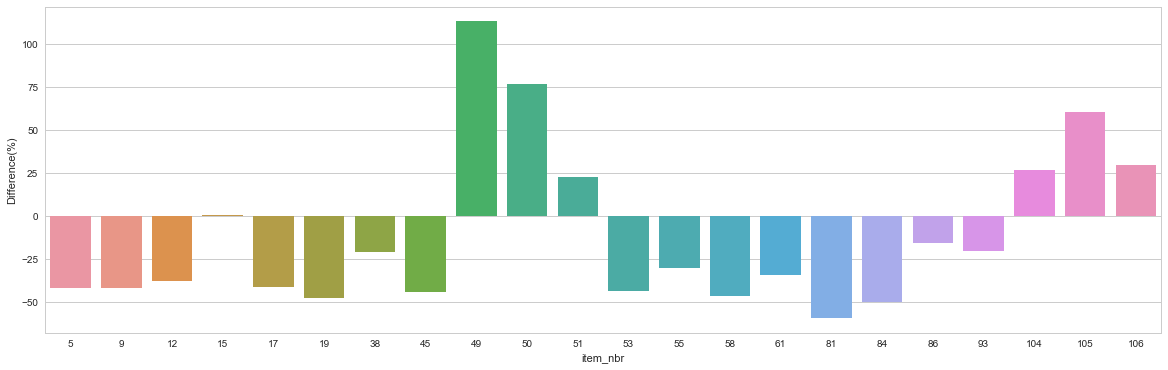

In [18]:
show_codesum_vs_units(13)

### 1. 1. 5. `holiday`  vs `units`

#### Add new column `dayofweek`

In [19]:
def make_year(date):
    return int(date.split('-')[0])
def make_month(date):
    return int(date.split('-')[1])
def make_day(date):
    return int(date.split('-')[2])
def make_monthday(date):
    return (date.split('-')[1:3])

In [20]:
def is_leap_year(year):
    return ((year % 4 == 0 and year % 100 != 0) or year % 400 == 0)

def sum_of_days(year,monthday):
    
    month = int(monthday[0])
    day = int(monthday[1])
    
    common_year = [
        31,
        28 + + int(is_leap_year(year)),
        31,
        30,
        31,
        30,
        31,
        31,
        30,
        31,
        30,
        31
    ]
    tmp_days = 0
    for i in range(month - 1):
        tmp_days += common_year[i]
    tmp_days += day
    return tmp_days

In [21]:
# 요일 구하는 함수
def check_week_of_day(year,days):
    
    if year == 2012:
        date_list = ['Sun', 'Mon', 'Tue', 'Wed', 'Thi', 'Fri', 'Sat']
        
    elif year == 2013:
        date_list = ['Tue', 'Wed', 'Thi', 'Fri', 'Sat', 'Sun', 'Mon']
    
    else:
        date_list = ['Wed', 'Thi', 'Fri', 'Sat', 'Sun', 'Mon','Tue']
    
    return date_list[days % 7 - 1]

In [22]:
weather_1['year'] = weather_1['date'].apply(make_year)
weather_1['month'] = weather_1['date'].apply(make_month)
weather_1['day'] = weather_1['date'].apply(make_day)
weather_1['monthday'] = weather_1['date'].apply(make_monthday)
weather_1['days'] = weather_1.apply(lambda row : sum_of_days(row['year'], row['monthday']), axis = 1)
weather_1['dayofweek'] = weather_1.apply(lambda row : check_week_of_day(row['year'], row['days']), axis = 1)

#### Add new column `weekend_YN`

In [23]:
def is_holiday(dayofweek):
    if dayofweek == "Sun" or dayofweek == "Sat":
        return 'weekend'
    else:
        return 'workday'

In [24]:
weather_1['weekend_YN'] = weather_1['dayofweek'].apply(is_holiday)

In [25]:
del weather_1['monthday']

In [26]:
weather_1.tail()

,station_nbr,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,...,sealevel,resultspeed,resultdir,avgspeed,year,month,day,days,dayofweek,weekend_YN
20512,16,2014-10-31,53,34,44,M,35,41,21,0,...,29.99,4.5,03,5.3,2014,10,31,304,Fri,workday
20513,17,2014-10-31,59,34,47,M,32,41,18,0,...,30.39,9.2,01,9.3,2014,10,31,304,Fri,workday
20514,18,2014-10-31,67,49,58,-4,40,50,7,0,...,30.28,10.6,36,11.2,2014,10,31,304,Fri,workday
20515,19,2014-10-31,45,33,39,-6,24,32,26,0,...,30.24,20.4,34,20.9,2014,10,31,304,Fri,workday
20516,20,2014-10-31,68,50,59,M,39,50,6,0,...,30.27,10.5,36,11.2,2014,10,31,304,Fri,workday


In [27]:
weather_1.to_csv('./data/add_holiday_weather.csv', sep = ',')

#### 위에서 저장한 오로지 팔린 item_nbr에 대한 데이터만 필터

- dayofweek : 요일
- holiday : 휴일 여부

In [28]:
df_tmp2 = pd.merge(train_key, weather_1)
df_tmp2 = df_tmp2[df_tmp2['units'] != 0]
df_tmp2 = df_tmp2.loc[:,['date', 'station_nbr', 'store_nbr', 'item_nbr', 'units', 'dayofweek', 'weekend_YN']]

In [29]:
df_tmp2.to_csv('./data/check_for_holiday_and_units.csv', sep = ',')

Pivot Table & Heatmap
- index 는 store > 팔린 품목
- columns 는 holiday, workday
- values = 3년간 sales의 평균

In [30]:
df_tmp2 = pd.read_csv('data/check_for_holiday_and_units.csv', index_col = 0)

In [31]:
pivot_data = df_tmp2.pivot_table(values = 'units', index = ['store_nbr','item_nbr'], columns=['weekend_YN']).fillna(value = 0).astype(int)

In [32]:
def check_heatmap_holiday(nbr):
    store_nbr = pivot_data.loc[nbr]
    fig = plt.figure(figsize=(25, 10))
    sns.heatmap(store_nbr, cmap="YlGnBu", annot = True, fmt = '.0f')

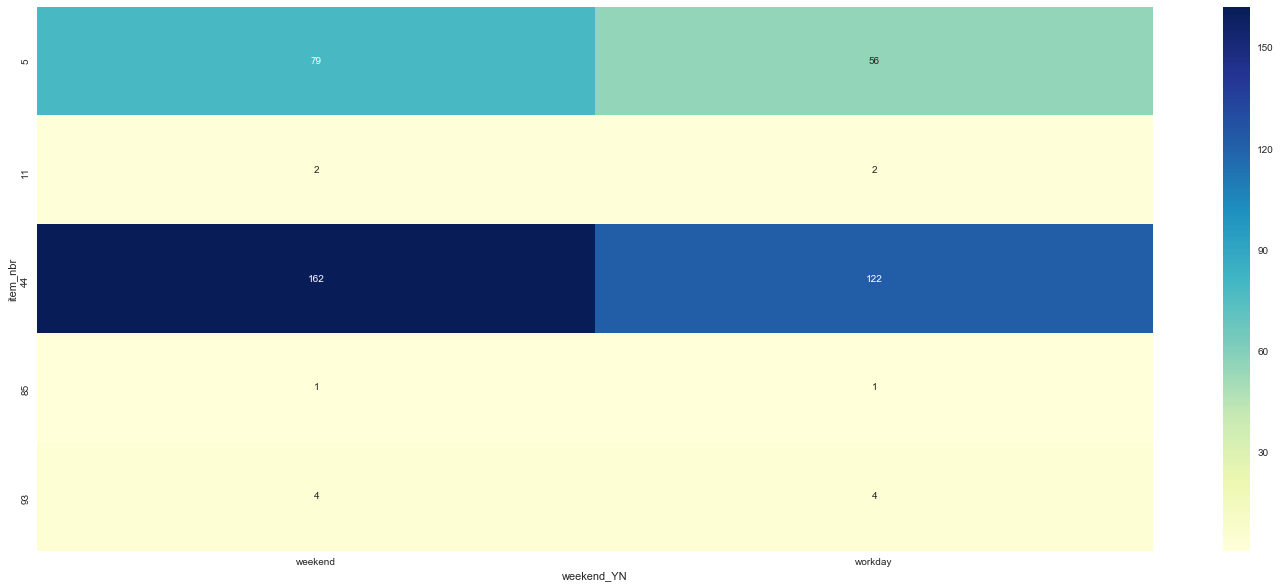

In [33]:
check_heatmap_holiday(2)

#### 특정 인기품목에 대해서는 주중에 비해 휴일이 sales가 높았던 것을 눈으로 확인할 수 있었습니다.
- 모델링할 때 휴일과 주중에 대한 컬럼변수도 고려할 수 있었다.

# 1. 2. Identify Missing Data

## 1. 2. 1. Transform all missing data into `np.nan`

In [34]:
for i in weather_1.columns:
    print(i, "\n", weather_1[i].unique())

station_nbr 
 [ 1  2  3  4  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20  5]
date 
 ['2012-01-01' '2012-01-02' '2012-01-03' ..., '2014-10-29' '2014-10-30'
 '2014-10-31']
tmax 
 ['52' '48' '55' '63' '50' '66' '34' '73' '72' '38' '56' '59' '46' '45' '60'
 '44' '21' '65' '43' '53' '25' '32' '28' '62' '61' '47' '30' '26' '71' '58'
 '39' '54' '23' '27' '31' '68' '70' '67' '36' '69' '74' '75' '33' '51' '57'
 '41' '49' '76' '35' '77' '64' '40' '16' '37' '42' '14' '22' '13' '10' '20'
 '24' '80' '4' '11' '78' '17' '18' '79' '29' '81' '82' '83' '88' '87' '92'
 '89' '84' '85' '86' '90' '91' '94' '93' '96' '95' 'M' '97' '98' '101' '99'
 '100' '105' '103' '102' '106' '104' '109' '107' '108' '110' '111' '112'
 '114' '113' '19' '15' '12' '-1' '5' '8' '9' '1' '6' '2' '3' '7' '-2' '-11'
 '-4' '-6' '0']
tmin 
 ['31' '33' '34' '47' '45' '19' '53' '48' '18' '26' '30' '38' '40' '25' '41'
 '28' '24' '37' '36' '11' '16' '29' '22' '35' '15' '9' '21' '27' '10' '5'
 '32' '20' '3' '8' '44' '46' '17' '55' '43' '57

### Types of Missing Data : ` - `, ` M `, ` T `, `  T`, `(blank)`

In [35]:
for i in weather_1.columns:
    weather_1[i] = weather_1[i].replace('-', np.nan)
    weather_1[i] = weather_1[i].replace(' ', np.nan)
    weather_1[i] = weather_1[i].replace('M', np.nan)
    weather_1[i] = weather_1[i].replace('T', np.nan)
    weather_1[i] = weather_1[i].replace('  T', np.nan)

## 1. 2. 2. Visualize Missing Data

### 1. 2. 2. 1. All

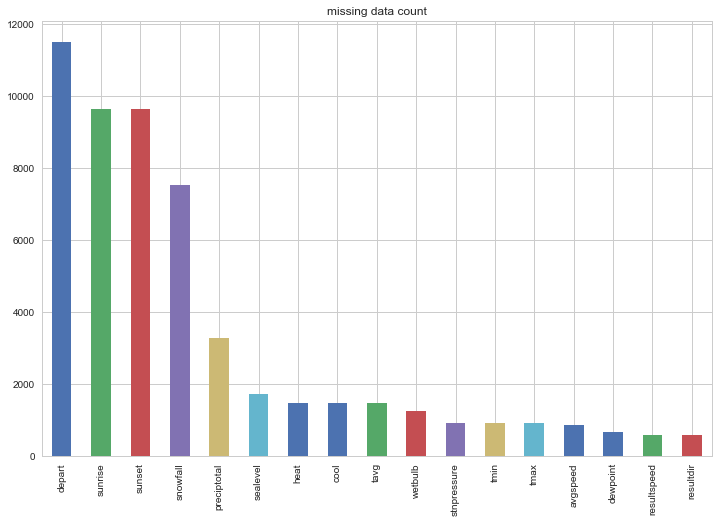

In [36]:
plt.figure(figsize=(12,8))
count_null = weather_1.isnull().sum()
count_null.sort_values(ascending = False, inplace = True)
count_null = count_null[count_null > 0]
count_null.plot(kind = 'bar', title = 'missing data count')
plt.show()

### 1. 2. 2. 2. Missing Data by each Station

In [37]:
def station_null(station_nbr):
    print("Total data size of station_" + str(station_nbr) + " : " + str(len(weather_1[weather_1['station_nbr'].isin([5])])))
    
    plt.figure(figsize=(16,4))
    count_null = weather_1[weather_1['station_nbr'].isin([station_nbr])].isnull().sum()
    count_null.sort_values(ascending = False, inplace = True)
    count_null = count_null[count_null > 0]
    count_null.plot(kind = 'bar', title = 'missing data count')
    plt.show()

Total data size of station_5 : 852


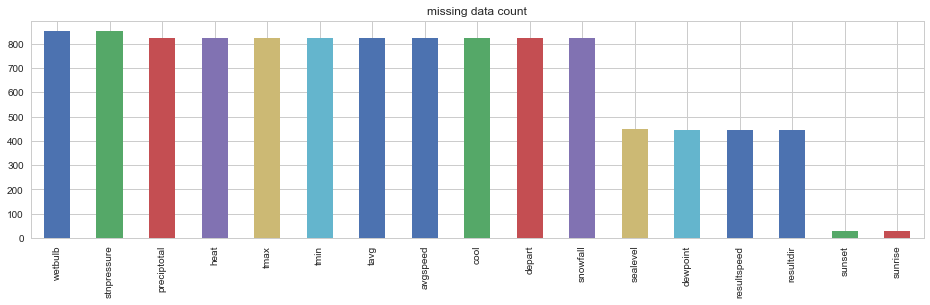

In [38]:
station_null(5)

# 2. Preprocessing

## 2. 1. Weather : Missing data imputation

### Weather 데이터의 Imputation을 위한 3가지 방법 도출

>#### 1. _Yesterday_ : 어제 날짜를 참조하여 복원

>#### 2. _Mean_ : 해당 station의 해당 feature의 평균으로 복원

>#### 3. _Closest_ : missing 행과 가장 비슷한 행을 찾아 복원

--------------------------

### 2. 1. 1. Weather data imputation : _Closest_ method

### 2. 1. 2. Merge all imputed weather data

In [39]:
from functools import reduce

each_station = []

for station_nbr in range(1,21):
    file_path = 'data/weather_imputation_v3/{:02}.csv'.format(station_nbr)
    station = pd.read_csv(file_path,index_col=0)
    station.dropna(axis=0,how='any',inplace=True)
    each_station.append(station)

weather = reduce((lambda x,y : x.append(y)),each_station)

In [40]:
weather = weather.reset_index(drop=True)
print(weather.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20512 entries, 0 to 20511
Data columns (total 23 columns):
station_nbr    20512 non-null int64
date           20512 non-null object
tmax           20512 non-null float64
tmin           20512 non-null float64
tavg           20512 non-null float64
depart         20512 non-null float64
dewpoint       20512 non-null float64
wetbulb        20512 non-null float64
heat           20512 non-null float64
cool           20512 non-null float64
sunrise        20512 non-null float64
sunset         20512 non-null float64
snowfall       20512 non-null float64
preciptotal    20512 non-null float64
stnpressure    20512 non-null float64
sealevel       20512 non-null float64
resultspeed    20512 non-null float64
resultdir      20512 non-null float64
avgspeed       20512 non-null float64
year           20512 non-null int64
month          20512 non-null int64
day            20512 non-null int64
codesum        20512 non-null object
dtypes: float64(17), int64(

## 2. 2. Encoding

### 2. 2. 1. `date` 

In [41]:
weather['year'] = weather['date'].apply(make_year)
weather['month'] = weather['date'].apply(make_month)
weather['day'] = weather['date'].apply(make_day)
weather['monthday'] = weather['date'].apply(make_monthday)
weather['days'] = weather.apply(lambda row : sum_of_days(row['year'], row['monthday']), axis = 1)
weather['dayofweek'] = weather.apply(lambda row : check_week_of_day(row['year'], row['days']), axis = 1)
weather['weekend_YN'] = weather['dayofweek'].apply(is_holiday)

In [42]:
weather

,station_nbr,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,...,resultdir,avgspeed,year,month,day,codesum,monthday,days,dayofweek,weekend_YN
0,1,2012-01-01,52.0,31.0,42.0,10.0,36.0,40.0,23.0,0.0,...,20.0,4.6,2012,1,1,RA FZFG BR,"[01, 01]",1,Sun,weekend
1,1,2012-01-02,50.0,31.0,41.0,23.0,26.0,35.0,24.0,0.0,...,24.0,10.3,2012,1,2,,"[01, 02]",2,Mon,workday
2,1,2012-01-03,32.0,11.0,22.0,2.0,4.0,18.0,43.0,0.0,...,31.0,11.6,2012,1,3,,"[01, 03]",3,Tue,workday
3,1,2012-01-04,28.0,9.0,19.0,15.0,1.0,14.0,46.0,0.0,...,27.0,8.3,2012,1,4,,"[01, 04]",4,Wed,workday
4,1,2012-01-05,38.0,25.0,32.0,7.0,13.0,25.0,33.0,0.0,...,25.0,7.8,2012,1,5,,"[01, 05]",5,Thi,workday
5,1,2012-01-06,46.0,25.0,36.0,8.0,21.0,29.0,29.0,0.0,...,1.0,2.4,2012,1,6,SN,"[01, 06]",6,Fri,workday
6,1,2012-01-07,57.0,28.0,43.0,10.0,28.0,36.0,22.0,0.0,...,26.0,3.6,2012,1,7,,"[01, 07]",7,Sat,weekend
7,1,2012-01-08,45.0,27.0,36.0,10.0,22.0,32.0,29.0,0.0,...,30.0,6.6,2012,1,8,,"[01, 08]",8,Sun,weekend
8,1,2012-01-09,39.0,23.0,31.0,8.0,12.0,25.0,34.0,0.0,...,23.0,4.0,2012,1,9,,"[01, 09]",9,Mon,workday
9,1,2012-01-10,47.0,29.0,38.0,10.0,24.0,32.0,27.0,0.0,...,25.0,6.5,2012,1,10,,"[01, 10]",10,Tue,workday


### 2. 2. 2. ` codesum `

#### 2. 2. 2. 1. Adding new column : `codesum_YN`

In [43]:
def codesum_YN(codesum):
    if codesum == " ":
        return 0 # as moderate
    else:
        return 1 # as codesum occured

In [44]:
weather['codesum_YN'] = weather['codesum'].apply(codesum_YN)

#### 2. 2. 2. 1. `codesum` by frequency

#### codesum 발생 빈도
- 'BC': 111,
- 'BL': 59,
- 'BR': 6359,
- 'DU': 28,
- 'DZ': 497,
- 'FG': 1307,
- 'FU': 33,
- 'FZ': 332,
- 'GR': 3,
- 'GS': 5,
- 'HZ': 1482,
- 'MI': 52,
- 'MO': 11051,
- 'PL': 20,
- 'PR': 1,
- 'RA': 5325,
- 'SG': 1,
- 'SN': 1008,
- 'SQ': 14,
- 'TS': 1888,
- 'UP': 230,
- 'VC': 571

#### 전처리 방식:
- 예를 들어 `RA,FG,FZ,BR` 이라는 코드섬이 있다면 `5325, 1307, 332, 6359` 로 변환 후
- 가장 높은 수를 가진 2개의 코드섬으로 변환 즉 `BR,RA`로 변환

In [45]:
# handling이 쉽도록 깔금하게 정리하는 코드
def ch_codesum(codesum):
    result = ""
    
    codesum = codesum.replace(" ","")
    codesum = codesum.replace("+","")
    
    for s in range(0,len(codesum)):
        if s % 2 == 0 and s != 0:
            result += ',' + codesum[s]
        else:
            result += codesum[s]
    return result

In [46]:
weather_tmp = pd.read_csv('./data/weather.csv', index_col = 0)
weather_tmp = weather.reset_index()

# 코드섬 카테고리작업을 위한 copy
weather_2 = weather.copy()
weather_2 = weather_2.loc[:,['date','codesum']]

# 함수적용
weather_2['codesum'] = weather_2['codesum'].apply(codesum_moderate)
weather_2['codesum'] = weather_2['codesum'].apply(ch_codesum)

from collections import Counter
codesum_list = list(weather_2['codesum'])
print(codesum_list[:10])

['RA,FZ,FG,BR', 'mo,de,ra,te', 'mo,de,ra,te', 'mo,de,ra,te', 'mo,de,ra,te', 'SN', 'mo,de,ra,te', 'mo,de,ra,te', 'mo,de,ra,te', 'mo,de,ra,te']


In [47]:
code_list = []
for i in codesum_list:
    i = list(set(i.split(',')))
    for j in i:
        code_list.append(j)
        
counts_code = dict(Counter(code_list))
print(counts_code)

{'FZ': 332, 'BR': 6358, 'FG': 1307, 'RA': 5324, 'ra': 11047, 'de': 11047, 'mo': 11047, 'te': 11047, 'SN': 1008, 'UP': 230, 'HZ': 1482, 'TS': 1888, 'VC': 571, 'BL': 59, 'DZ': 497, 'DU': 28, 'BC': 111, 'FU': 33, 'PL': 20, 'MI': 52, 'GR': 3, 'SQ': 14, 'GS': 5, 'SG': 1, 'PR': 1}


#### Select Top_2 frequent codesum

In [48]:
def codesum_two(codesum):
    codesum = codesum.split(',')
    if len(codesum) >= 2:
        tmp_code = []
        tmp_list = list(set([counts_code[code] for code in codesum]))
        tmp_list.sort()
        tmp_list.reverse()
        top2_code = tmp_list[:2]
        for idx,val in counts_code.items():
            if val in top2_code:
                tmp_code.append(idx)
            else:
                continue
        return ",".join(tmp_code)
    return ",".join(codesum)

In [49]:
weather_2['codesum'] = weather_2['codesum'].apply(codesum_two)

counts_codesum_set = dict(Counter(weather_2['codesum']))

sum_percentage = 0
for idx,val in counts_codesum_set.items():
    
    if val > 1000:
        percentage = round((val / 20517) * 100,2)
        print(idx," "*(12 - len(idx)),val," "*(7 - len(str(val))),str(percentage)+"%")
        sum_percentage += percentage
            
print("-------total_percentage---------")
print(str(sum_percentage) + "%")

BR,RA         3311     16.14%
ra,de,mo,te   11047    53.84%
RA            1281     6.24%
BR            1431     6.97%
-------total_percentage---------
83.19%


#### Other codesums as `AN`

In [50]:
def convert_codesum(codesum):
    if codesum == "BR" or codesum == "RA" or codesum == "BR,RA" or codesum == "MO":
        return codesum
    else:
        return "AN"

In [51]:
weather_2['codesum'] = weather_2['codesum'].apply(convert_codesum)
weather_2['codesum'].unique()

array(['BR,RA', 'AN', 'RA', 'BR'], dtype=object)

#### Replace with `codesum` column

In [52]:
del weather['codesum']
weather['codesum'] = weather_2['codesum']

In [53]:
weather['codesum'].unique()

array(['BR,RA', 'AN', 'RA', 'BR'], dtype=object)

In [54]:
print(weather.shape)
weather

(20512, 28)


,station_nbr,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,...,avgspeed,year,month,day,monthday,days,dayofweek,weekend_YN,codesum_YN,codesum
0,1,2012-01-01,52.0,31.0,42.0,10.0,36.0,40.0,23.0,0.0,...,4.6,2012,1,1,"[01, 01]",1,Sun,weekend,1,"BR,RA"
1,1,2012-01-02,50.0,31.0,41.0,23.0,26.0,35.0,24.0,0.0,...,10.3,2012,1,2,"[01, 02]",2,Mon,workday,0,AN
2,1,2012-01-03,32.0,11.0,22.0,2.0,4.0,18.0,43.0,0.0,...,11.6,2012,1,3,"[01, 03]",3,Tue,workday,0,AN
3,1,2012-01-04,28.0,9.0,19.0,15.0,1.0,14.0,46.0,0.0,...,8.3,2012,1,4,"[01, 04]",4,Wed,workday,0,AN
4,1,2012-01-05,38.0,25.0,32.0,7.0,13.0,25.0,33.0,0.0,...,7.8,2012,1,5,"[01, 05]",5,Thi,workday,0,AN
5,1,2012-01-06,46.0,25.0,36.0,8.0,21.0,29.0,29.0,0.0,...,2.4,2012,1,6,"[01, 06]",6,Fri,workday,1,AN
6,1,2012-01-07,57.0,28.0,43.0,10.0,28.0,36.0,22.0,0.0,...,3.6,2012,1,7,"[01, 07]",7,Sat,weekend,0,AN
7,1,2012-01-08,45.0,27.0,36.0,10.0,22.0,32.0,29.0,0.0,...,6.6,2012,1,8,"[01, 08]",8,Sun,weekend,0,AN
8,1,2012-01-09,39.0,23.0,31.0,8.0,12.0,25.0,34.0,0.0,...,4.0,2012,1,9,"[01, 09]",9,Mon,workday,0,AN
9,1,2012-01-10,47.0,29.0,38.0,10.0,24.0,32.0,27.0,0.0,...,6.5,2012,1,10,"[01, 10]",10,Tue,workday,0,AN


#### 2. 3. 2. 1. Final Merge : 

In [55]:
df = pd.merge(train_key, weather)
print(df.shape)
df.head()

(4616490, 31)


,store_nbr,station_nbr,date,item_nbr,units,tmax,tmin,tavg,depart,dewpoint,...,avgspeed,year,month,day,monthday,days,dayofweek,weekend_YN,codesum_YN,codesum
0,1,1,2012-01-01,1,0,52.0,31.0,42.0,10.0,36.0,...,4.6,2012,1,1,"[01, 01]",1,Sun,weekend,1,"BR,RA"
1,1,1,2012-01-01,2,0,52.0,31.0,42.0,10.0,36.0,...,4.6,2012,1,1,"[01, 01]",1,Sun,weekend,1,"BR,RA"
2,1,1,2012-01-01,3,0,52.0,31.0,42.0,10.0,36.0,...,4.6,2012,1,1,"[01, 01]",1,Sun,weekend,1,"BR,RA"
3,1,1,2012-01-01,4,0,52.0,31.0,42.0,10.0,36.0,...,4.6,2012,1,1,"[01, 01]",1,Sun,weekend,1,"BR,RA"
4,1,1,2012-01-01,5,0,52.0,31.0,42.0,10.0,36.0,...,4.6,2012,1,1,"[01, 01]",1,Sun,weekend,1,"BR,RA"


# 3. OLS 모델링

### 변수 : 
- 종속변수 : `units`
- 독립변수 : weather features, date

### Condition :
- 판매가 이루어진 data에 한해 분석을 한다.
- `units`= 0 인 데이터는 제외한다. 

In [56]:
df_test = df[df['units'] != 0]
print(df_test.shape)
df_test.head()

(118664, 31)


,store_nbr,station_nbr,date,item_nbr,units,tmax,tmin,tavg,depart,dewpoint,...,avgspeed,year,month,day,monthday,days,dayofweek,weekend_YN,codesum_YN,codesum
8,1,1,2012-01-01,9,29,52.0,31.0,42.0,10.0,36.0,...,4.6,2012,1,1,"[01, 01]",1,Sun,weekend,1,"BR,RA"
27,1,1,2012-01-01,28,2,52.0,31.0,42.0,10.0,36.0,...,4.6,2012,1,1,"[01, 01]",1,Sun,weekend,1,"BR,RA"
50,1,1,2012-01-01,51,1,52.0,31.0,42.0,10.0,36.0,...,4.6,2012,1,1,"[01, 01]",1,Sun,weekend,1,"BR,RA"
119,1,1,2012-01-02,9,60,50.0,31.0,41.0,23.0,26.0,...,10.3,2012,1,2,"[01, 02]",2,Mon,workday,0,AN
138,1,1,2012-01-02,28,5,50.0,31.0,41.0,23.0,26.0,...,10.3,2012,1,2,"[01, 02]",2,Mon,workday,0,AN


# 3. 1. OLS  : First Approach

$$ \text{units} = \text{C(store_nbr)} + \text{C(item_nbr)} + \text{avgspeed} + \text{cool} + \text{depart} + \text{dewpoint} + \text{heat} + \text{preciptotal} + \text{resultdir} + \text{resultspeed} + \text{sealevel} + \text{snowfall} + \text{stnpressure} + \text{tavg} + \text{tmax} + \text{tmin} + \text{wetbulb} $$

In [57]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

tmp = df_test.copy()

In [58]:
formula = 'units ~ C(store_nbr) + C(item_nbr)+ avgspeed + cool + depart + dewpoint + heat + preciptotal + resultdir + resultspeed + sealevel + snowfall + stnpressure + tavg + tmax + tmin + wetbulb'
model = sm.OLS.from_formula(formula,data=tmp)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                  units   R-squared:                       0.584
Model:                            OLS   Adj. R-squared:                  0.584
Method:                 Least Squares   F-statistic:                     986.1
Date:                Thu, 15 Mar 2018   Prob (F-statistic):               0.00
Time:                        13:13:26   Log-Likelihood:            -5.7703e+05
No. Observations:              118664   AIC:                         1.154e+06
Df Residuals:                  118494   BIC:                         1.156e+06
Df Model:                         169                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            164.7663     22

### 3. 1. 1. Eliminate Outliers

In [59]:
# 1차 제거
res = result.resid_pearson
index = result.resid.index
outlier_index = abs(res) >= 2

row = pd.Series(index=index, data=res)
drop_index = row[outlier_index].index
tmp.drop(list(drop_index),inplace=True)
tmp.reset_index(drop=True,inplace=True)

model = sm.OLS.from_formula(formula,tmp)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                  units   R-squared:                       0.756
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                     2114.
Date:                Thu, 15 Mar 2018   Prob (F-statistic):               0.00
Time:                        13:13:33   Log-Likelihood:            -5.0032e+05
No. Observations:              115306   AIC:                         1.001e+06
Df Residuals:                  115136   BIC:                         1.003e+06
Df Model:                         169                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            121.5137     13

In [60]:
# 2차 
res = result.resid_pearson
index = result.resid.index
outlier_index = abs(res) >= 2

row = pd.Series(index=index, data=res)
drop_index = row[outlier_index].index
tmp.drop(list(drop_index),inplace=True)
tmp.reset_index(drop=True,inplace=True)

model = sm.OLS.from_formula(formula,data=tmp)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                  units   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     2823.
Date:                Thu, 15 Mar 2018   Prob (F-statistic):               0.00
Time:                        13:13:38   Log-Likelihood:            -4.3579e+05
No. Observations:              107773   AIC:                         8.719e+05
Df Residuals:                  107603   BIC:                         8.736e+05
Df Model:                         169                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             87.7424     10

### 3. 1. 2. Check Multicolinearity (VIF)

In [61]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [62]:
df_for_vif = tmp[['tmax', 'tmin',
       'tavg', 'depart', 'dewpoint', 'wetbulb', 'heat', 'cool', 'sunrise',
       'sunset', 'snowfall', 'preciptotal', 'stnpressure', 'sealevel',
       'resultspeed', 'resultdir', 'avgspeed']]

In [63]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(df_for_vif.values, i) for i in range(df_for_vif.shape[1])]
vif["features"] = df_for_vif.columns
vif.sort_values(by=['VIF Factor'], ascending=False).reset_index(drop=True)

,VIF Factor,features
0,19325.514061,tavg
1,15847.412719,sealevel
2,1888.073907,tmax
3,1818.193421,wetbulb
4,1537.101983,sunset
5,1008.376484,tmin
6,909.034277,heat
7,453.615794,stnpressure
8,336.319582,dewpoint
9,300.602981,cool


In [64]:
del df_for_vif ['tavg']

In [65]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(df_for_vif.values, i) for i in range(df_for_vif.shape[1])]
vif["features"] = df_for_vif.columns
vif.sort_values(by=['VIF Factor'], ascending=False).reset_index(drop=True)

,VIF Factor,features
0,6213.035719,sealevel
1,1813.734855,wetbulb
2,1534.803732,sunset
3,1339.906967,tmax
4,712.984985,tmin
5,450.058470,stnpressure
6,336.258192,dewpoint
7,254.170657,heat
8,110.944367,sunrise
9,85.671971,cool


In [66]:
del df_for_vif ['sealevel']

In [67]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(df_for_vif.values, i) for i in range(df_for_vif.shape[1])]
vif["features"] = df_for_vif.columns
vif.sort_values(by=['VIF Factor'], ascending=False).reset_index(drop=True)

,VIF Factor,features
0,1738.651775,wetbulb
1,1089.475802,sunset
2,690.869233,tmax
3,417.710072,tmin
4,415.504880,stnpressure
5,319.096963,dewpoint
6,94.177070,sunrise
7,93.615655,heat
8,33.123185,avgspeed
9,31.841963,cool


In [68]:
del df_for_vif['wetbulb']

In [69]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(df_for_vif.values, i) for i in range(df_for_vif.shape[1])]
vif["features"] = df_for_vif.columns
vif.sort_values(by=['VIF Factor'], ascending=False).reset_index(drop=True)

,VIF Factor,features
0,1065.466552,sunset
1,579.362411,tmax
2,398.028689,stnpressure
3,367.781269,tmin
4,94.065619,sunrise
5,90.625093,heat
6,77.062926,dewpoint
7,33.123124,avgspeed
8,31.718822,cool
9,21.013594,resultspeed


In [70]:
del df_for_vif['sunset']

In [71]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(df_for_vif.values, i) for i in range(df_for_vif.shape[1])]
vif["features"] = df_for_vif.columns
vif.sort_values(by=['VIF Factor'], ascending=False).reset_index(drop=True)

,VIF Factor,features
0,382.544834,stnpressure
1,191.119679,tmin
2,157.406387,tmax
3,76.801825,dewpoint
4,65.868865,sunrise
5,32.599060,avgspeed
6,26.059682,heat
7,20.836756,resultspeed
8,11.779503,cool
9,4.910866,resultdir


In [72]:
del df_for_vif['stnpressure']

In [73]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(df_for_vif.values, i) for i in range(df_for_vif.shape[1])]
vif["features"] = df_for_vif.columns
vif.sort_values(by=['VIF Factor'], ascending=False).reset_index(drop=True)

,VIF Factor,features
0,155.362476,tmin
1,90.450131,tmax
2,67.000150,dewpoint
3,60.161199,sunrise
4,29.520562,avgspeed
5,18.621734,resultspeed
6,7.158389,heat
7,5.405786,cool
8,4.881848,resultdir
9,2.869105,depart


In [74]:
del df_for_vif['tmin']

In [75]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(df_for_vif.values, i) for i in range(df_for_vif.shape[1])]
vif["features"] = df_for_vif.columns
vif.sort_values(by=['VIF Factor'], ascending=False).reset_index(drop=True)

,VIF Factor,features
0,73.004586,tmax
1,58.369582,sunrise
2,32.990683,dewpoint
3,29.058255,avgspeed
4,18.618925,resultspeed
5,6.475820,heat
6,4.873052,resultdir
7,4.334837,cool
8,2.868968,depart
9,1.192982,preciptotal


In [76]:
del df_for_vif['tmax']

In [77]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(df_for_vif.values, i) for i in range(df_for_vif.shape[1])]
vif["features"] = df_for_vif.columns
vif.sort_values(by=['VIF Factor'], ascending=False).reset_index(drop=True)

,VIF Factor,features
0,31.955080,sunrise
1,26.348709,avgspeed
2,25.817087,dewpoint
3,17.318263,resultspeed
4,4.896888,heat
5,4.629065,resultdir
6,3.538389,cool
7,2.848883,depart
8,1.170148,preciptotal
9,1.049253,snowfall


In [78]:
del df_for_vif['sunrise']

In [79]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(df_for_vif.values, i) for i in range(df_for_vif.shape[1])]
vif["features"] = df_for_vif.columns
vif.sort_values(by=['VIF Factor'], ascending=False).reset_index(drop=True)

,VIF Factor,features
0,24.880120,avgspeed
1,16.890490,resultspeed
2,8.265732,dewpoint
3,4.440485,resultdir
4,3.036334,cool
5,2.737818,depart
6,2.354862,heat
7,1.139951,preciptotal
8,1.049193,snowfall


In [80]:
del df_for_vif['avgspeed']

In [81]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(df_for_vif.values, i) for i in range(df_for_vif.shape[1])]
vif["features"] = df_for_vif.columns
vif.sort_values(by=['VIF Factor'], ascending=False).reset_index(drop=True)

,VIF Factor,features
0,7.653518,dewpoint
1,4.255451,resultdir
2,3.227764,resultspeed
3,3.022876,cool
4,2.710800,depart
5,2.284297,heat
6,1.132089,preciptotal
7,1.049086,snowfall


In [82]:
formula = 'units ~ C(store_nbr) + C(item_nbr)+ scale(cool) + scale(depart) + scale(heat) + scale(preciptotal) + scale(resultdir) + scale(snowfall) + scale(dewpoint) + scale(resultspeed)'
model = sm.OLS.from_formula(formula, data=tmp)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  units   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     2941.
Date:                Thu, 15 Mar 2018   Prob (F-statistic):               0.00
Time:                        13:14:08   Log-Likelihood:            -4.3586e+05
No. Observations:              107773   AIC:                         8.720e+05
Df Residuals:                  107610   BIC:                         8.736e+05
Df Model:                         162                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              9.8959      0.969     10.216      0.000       7.997      11.795
C(store_nbr)[T.2]     32.4544      0.579     56.035      0.000      31.319      33.590
C(store_nbr)[T.3]     18.6921      0.539     34.660      0.000      17.635      19.749
C(store_nbr)[T.4]     70.4228      0.738     95.467      0.000      68.977      71.869
C(store_nbr)[T.5]     15.6890      0.566     27.723      0.000      14.580      16.798
C(store_nbr)[T.6]     15.3525      0.545     28.181      0.000      14.285      16.420
C(store_nbr)[T.7]     24.5802      0.602     40.834      0.000      23.400      25.760
C(store_nbr)[T.8]      6.6932      0.581     11.524      0.000       5.555       7.832
C(store_nbr)[T.9]     17.4895      0.539     32.446      0.000      16.433      18.546
C(store_nbr)[T.10]    20.4513      0.543     37.632      0.000      19.386      21.516
C(store_nbr)[T.11]    10.4200      0.531     19.638      0.000       9.380      11.460
C(store_nbr)[T.12]    21.9682      0.561     39.135      0.000      20.868      23.068
C(store_nbr)[T.13]    32.8050      0.585     56.106      0.000      31.659      33.951
C(store_nbr)[T.14]   -31.5896      0.590    -53.586      0.000     -32.745     -30.434
C(store_nbr)[T.15]    23.5014      0.528     44.477      0.000      22.466      24.537
C(store_nbr)[T.16]    33.7235      0.601     56.154      0.000      32.546      34.901
C(store_nbr)[T.17]    70.7469      0.599    118.072      0.000      69.573      71.921
C(store_nbr)[T.18]     1.9208      0.558      3.444      0.001       0.828       3.014
C(store_nbr)[T.19]     9.7330      0.622     15.652      0.000       8.514      10.952
C(store_nbr)[T.20]    26.7217      0.612     43.637      0.000      25.522      27.922
C(store_nbr)[T.21]     4.4948      0.567      7.928      0.000       3.384       5.606
C(store_nbr)[T.22]    13.5039      0.530     25.466      0.000      12.465      14.543
C(store_nbr)[T.23]    -4.1824      0.541     -7.733      0.000      -5.242      -3.122
C(store_nbr)[T.24]    72.4080      2.098     34.512      0.000      68.296      76.520
C(store_nbr)[T.25]    33.0804      0.532     62.224      0.000      32.038      34.122
C(store_nbr)[T.26]     5.5439      0.541     10.239      0.000       4.483       6.605
C(store_nbr)[T.27]     7.9730      0.517     15.410      0.000       6.959       8.987
C(store_nbr)[T.28]     3.8255      0.549      6.970      0.000       2.750       4.901
C(store_nbr)[T.29]    15.4621      0.586     26.398      0.000      14.314      16.610
C(store_nbr)[T.30]    29.0036      0.608     47.693      0.000      27.812      30.196
C(store_nbr)[T.31]    24.3905      0.517     47.158      0.000      23.377      25.404
C(store_nbr)[T.32]     3.7081      0.499      7.429      0.000       2.730       4.686
C(store_nbr)[T.33]    88.0603      0.6

### 3. 1. 3. Add  `weekend`, `codesum` as features

### 3. 1. 4. Check Normality Test, Log-Likelihood

In [83]:
formula = 'units ~ C(store_nbr) + C(item_nbr) + scale(cool) + scale(depart) + scale(heat) + scale(preciptotal) + scale(resultdir) + scale(snowfall) + scale(dewpoint) + scale(resultspeed) + C(weekend_YN)'

In [84]:
model = sm.OLS.from_formula(formula,data=tmp)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  units   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.821
Method:                 Least Squares   F-statistic:                     3026.
Date:                Thu, 15 Mar 2018   Prob (F-statistic):               0.00
Time:                        13:14:22   Log-Likelihood:            -4.3433e+05
No. Observations:              107773   AIC:                         8.690e+05
Df Residuals:                  107609   BIC:                         8.706e+05
Df Model:                         163                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   13.5342      0.957     14.138      0.000      11.658      15.410
C(store_nbr)[T.2]           32.5812      0.571     57.059      0.000      31.462      33.700
C(store_nbr)[T.3]           18.7296      0.532     35.227      0.000      17.687      19.772
C(store_nbr)[T.4]           70.7019      0.727     97.216      0.000      69.277      72.127
C(store_nbr)[T.5]           15.8088      0.558     28.335      0.000      14.715      16.902
C(store_nbr)[T.6]           15.2672      0.537     28.425      0.000      14.214      16.320
C(store_nbr)[T.7]           24.6773      0.593     41.583      0.000      23.514      25.840
C(store_nbr)[T.8]            6.7354      0.573     11.762      0.000       5.613       7.858
C(store_nbr)[T.9]           17.4508      0.531     32.838      0.000      16.409      18.492
C(store_nbr)[T.10]          20.6125      0.536     38.471      0.000      19.562      21.663
C(store_nbr)[T.11]          10.4430      0.523     19.964      0.000       9.418      11.468
C(store_nbr)[T.12]          22.1353      0.553     39.997      0.000      21.051      23.220
C(store_nbr)[T.13]          32.9145      0.576     57.099      0.000      31.785      34.044
C(store_nbr)[T.14]         -31.8535      0.581    -54.805      0.000     -32.993     -30.714
C(store_nbr)[T.15]          23.7022      0.521     45.498      0.000      22.681      24.723
C(store_nbr)[T.16]          33.9031      0.592     57.261      0.000      32.743      35.064
C(store_nbr)[T.17]          70.8355      0.591    119.912      0.000      69.678      71.993
C(store_nbr)[T.18]           1.9224      0.550      3.496      0.000       0.845       3.000
C(store_nbr)[T.19]           9.8386      0.613     16.048      0.000       8.637      11.040
C(store_nbr)[T.20]          26.8073      0.604     44.403      0.000      25.624      27.991
C(store_nbr)[T.21]           4.3913      0.559      7.856      0.000       3.296       5.487
C(store_nbr)[T.22]          13.5391      0.523     25.898      0.000      12.514      14.564
C(store_nbr)[T.23]          -4.3009      0.533     -8.066      0.000      -5.346      -3.256
C(store_nbr)[T.24]          72.9512      2.068     35.268      0.000      68.897      77.005
C(store_nbr)[T.25]          33.0818      0.524     63.117      0.000      32.055      34.109
C(store_nbr)[T.26]           5.4630      0.534     10.234      0.000       4.417       6.509
C(store_nbr)[T.27]           7.9897      0.510     15.663      0.000       6.990       8.990
C(store_nbr)[T.28]           3.7578      0.541      6.944      0.000       2.697       4.818
C(store_nbr)[T.29]          15.4293      0.577     26.719      0.000      14.298      16.561
C(store_nbr)[T.30]          29.1578      0.600     48.633      0.000      27.983      30.333
C(store_nbr)[T

### 3. 1. 5. Target vs Nuperical Features

In [85]:
formula

'units ~ C(store_nbr) + C(item_nbr) + scale(cool) + scale(depart) + scale(heat) + scale(preciptotal) + scale(resultdir) + scale(snowfall) + scale(dewpoint) + scale(resultspeed) + C(weekend_YN)'

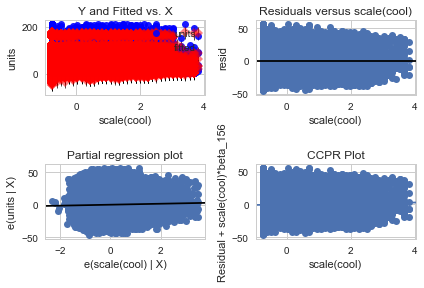

In [86]:
fig = sm.graphics.plot_regress_exog(result, "scale(cool)")
fig.suptitle("")
plt.show()

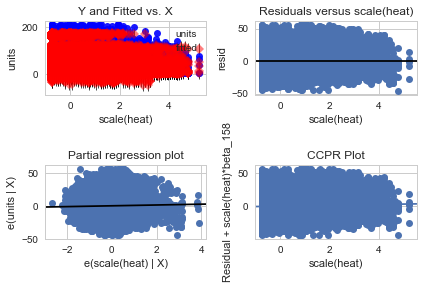

In [87]:
fig = sm.graphics.plot_regress_exog(result, "scale(heat)")
fig.suptitle("")
plt.show()

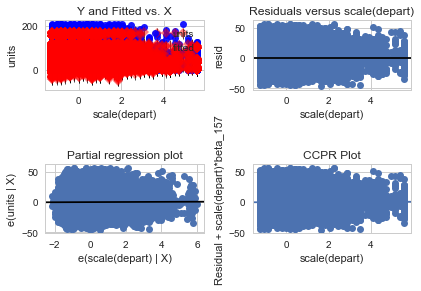

In [88]:
fig = sm.graphics.plot_regress_exog(result, "scale(depart)")
fig.suptitle("")
plt.show()

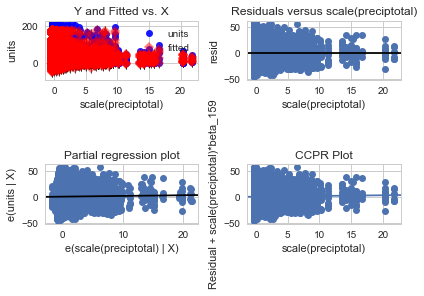

In [89]:
fig = sm.graphics.plot_regress_exog(result, "scale(preciptotal)")
fig.suptitle("")
plt.show()

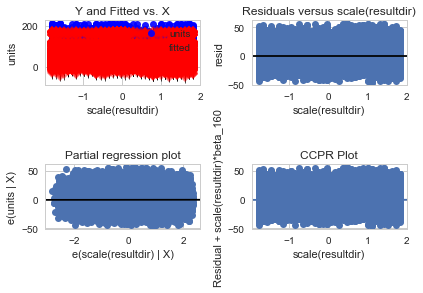

In [90]:
fig = sm.graphics.plot_regress_exog(result, "scale(resultdir)")
fig.suptitle("")
plt.show()

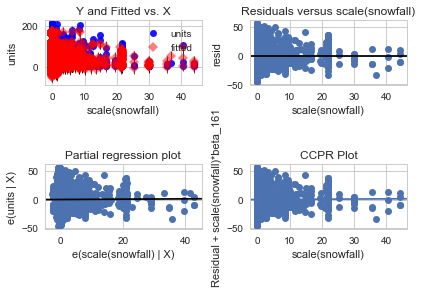

In [91]:
fig = sm.graphics.plot_regress_exog(result, "scale(snowfall)")
fig.suptitle("")
plt.show()

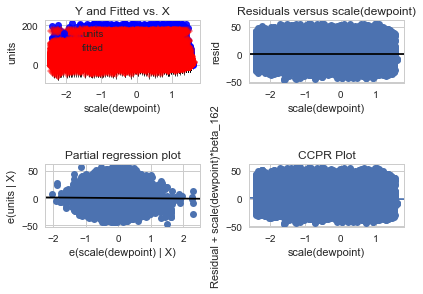

In [92]:
fig = sm.graphics.plot_regress_exog(result, "scale(dewpoint)")
fig.suptitle("")
plt.show()

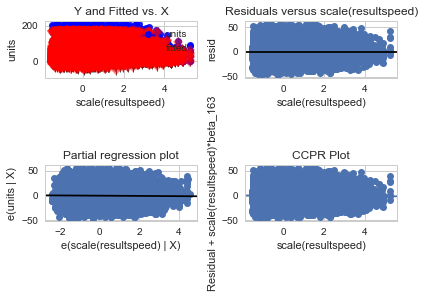

In [93]:
fig = sm.graphics.plot_regress_exog(result, "scale(resultspeed)")
fig.suptitle("")
plt.show()

### 3. 1. 6. Only Categorial Variables as features

In [94]:
formula = 'units ~ C(store_nbr) + C(item_nbr)'
model = sm.OLS.from_formula(formula,data=tmp)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  units   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     3082.
Date:                Thu, 15 Mar 2018   Prob (F-statistic):               0.00
Time:                        13:16:27   Log-Likelihood:            -4.3602e+05
No. Observations:              107773   AIC:                         8.723e+05
Df Residuals:                  107618   BIC:                         8.738e+05
Df Model:                         154                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              9.9285      0.970     10.236      0.000       8.027      11.830
C(store_nbr)[T.2]     32.1105      0.577     55.609      0.000      30.979      33.242
C(store_nbr)[T.3]     18.3696      0.536     34.241      0.000      17.318      19.421
C(store_nbr)[T.4]     70.5786      0.738     95.628      0.000      69.132      72.025
C(store_nbr)[T.5]     15.2385      0.564     27.021      0.000      14.133      16.344
C(store_nbr)[T.6]     15.0179      0.543     27.672      0.000      13.954      16.082
C(store_nbr)[T.7]     24.1937      0.601     40.273      0.000      23.016      25.371
C(store_nbr)[T.8]      6.5531      0.579     11.312      0.000       5.418       7.688
C(store_nbr)[T.9]     17.3511      0.539     32.197      0.000      16.295      18.407
C(store_nbr)[T.10]    19.9788      0.541     36.908      0.000      18.918      21.040
C(store_nbr)[T.11]     9.9827      0.528     18.909      0.000       8.948      11.017
C(store_nbr)[T.12]    21.4517      0.559     38.376      0.000      20.356      22.547
C(store_nbr)[T.13]    32.4373      0.584     55.589      0.000      31.294      33.581
C(store_nbr)[T.14]   -31.6049      0.590    -53.593      0.000     -32.761     -30.449
C(store_nbr)[T.15]    23.7513      0.525     45.225      0.000      22.722      24.781
C(store_nbr)[T.16]    33.5944      0.600     56.002      0.000      32.419      34.770
C(store_nbr)[T.17]    70.5457      0.598    117.951      0.000      69.373      71.718
C(store_nbr)[T.18]     1.8158      0.558      3.256      0.001       0.723       2.909
C(store_nbr)[T.19]     9.9015      0.622     15.928      0.000       8.683      11.120
C(store_nbr)[T.20]    26.3913      0.610     43.265      0.000      25.196      27.587
C(store_nbr)[T.21]     4.2498      0.566      7.504      0.000       3.140       5.360
C(store_nbr)[T.22]    13.0976      0.528     24.822      0.000      12.063      14.132
C(store_nbr)[T.23]    -4.3183      0.541     -7.987      0.000      -5.378      -3.259
C(store_nbr)[T.24]    72.5079      2.101     34.512      0.000      68.390      76.626
C(store_nbr)[T.25]    33.2787      0.528     63.005      0.000      32.244      34.314
C(store_nbr)[T.26]     5.4146      0.541     10.002      0.000       4.354       6.476
C(store_nbr)[T.27]     7.5514      0.515     14.671      0.000       6.543       8.560
C(store_nbr)[T.28]     3.5116      0.546      6.430      0.000       2.441       4.582
C(store_nbr)[T.29]    15.1893      0.585     25.962      0.000      14.043      16.336
C(store_nbr)[T.30]    29.0026      0.608     47.716      0.000      27.811      30.194
C(store_nbr)[T.31]    24.2253      0.517     46.868      0.000      23.212      25.238
C(store_nbr)[T.32]     3.9297      0.495      7.932      0.000       2.959       4.901
C(store_nbr)[T.33]    87.8428      0.6

# 3. 2. OLS : Second Approach

$$ \text{units} = \text{cat}_1 + \text{cat}_2 + \text{cat}_1 + \cdot\cdot\cdot + \text{cat}_i$$

In [95]:
tmp2 = df_test.copy()

In [96]:
print(tmp2.shape)
tmp2.head()

(118664, 31)


,store_nbr,station_nbr,date,item_nbr,units,tmax,tmin,tavg,depart,dewpoint,...,avgspeed,year,month,day,monthday,days,dayofweek,weekend_YN,codesum_YN,codesum
8,1,1,2012-01-01,9,29,52.0,31.0,42.0,10.0,36.0,...,4.6,2012,1,1,"[01, 01]",1,Sun,weekend,1,"BR,RA"
27,1,1,2012-01-01,28,2,52.0,31.0,42.0,10.0,36.0,...,4.6,2012,1,1,"[01, 01]",1,Sun,weekend,1,"BR,RA"
50,1,1,2012-01-01,51,1,52.0,31.0,42.0,10.0,36.0,...,4.6,2012,1,1,"[01, 01]",1,Sun,weekend,1,"BR,RA"
119,1,1,2012-01-02,9,60,50.0,31.0,41.0,23.0,26.0,...,10.3,2012,1,2,"[01, 02]",2,Mon,workday,0,AN
138,1,1,2012-01-02,28,5,50.0,31.0,41.0,23.0,26.0,...,10.3,2012,1,2,"[01, 02]",2,Mon,workday,0,AN


### 3. 2. 1. OLS

In [97]:
formula = ('np.log(units) ~ C(store_nbr) + C(item_nbr) + C(day) + C(dayofweek) + C(codesum)')
model = sm.OLS.from_formula(formula, data=tmp2)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:          np.log(units)   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     3657.
Date:                Thu, 15 Mar 2018   Prob (F-statistic):               0.00
Time:                        13:16:37   Log-Likelihood:            -1.0604e+05
No. Observations:              118664   AIC:                         2.125e+05
Df Residuals:                  118470   BIC:                         2.143e+05
Df Model:                         193                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.8316    

### 3. 2. 2.  `codesum` modification
- BR, RA 코드는 p-value 높게 나옴
- RA로 변경

In [98]:
def convert_codesum2(codesum):
    if codesum == "BR,RA":
        return "RA"
    else:
        return codesum

In [99]:
tmp2['codesum'] = tmp2['codesum'].apply(convert_codesum2)

In [100]:
formula = ('np.log(units) ~ C(store_nbr) + C(item_nbr) + C(day) + C(dayofweek) + C(codesum)')
model = sm.OLS.from_formula(formula, data= tmp2)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:          np.log(units)   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     3675.
Date:                Thu, 15 Mar 2018   Prob (F-statistic):               0.00
Time:                        13:16:45   Log-Likelihood:            -1.0605e+05
No. Observations:              118664   AIC:                         2.125e+05
Df Residuals:                  118471   BIC:                         2.144e+05
Df Model:                         192                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.8317    

### 3. 2. 3 Eliminate Outlier 

In [101]:
res = result.resid_pearson
index = result.resid.index
outlier_index = abs(res) >= 2

row = pd.Series(index=index, data=res)
drop_index = row[outlier_index].index
len(drop_index)

tmp2.drop(list(drop_index),inplace=True)
tmp2.reset_index(drop = True, inplace = True)
len(tmp2)

112783

In [102]:
formula = ('np.log(units) ~ C(store_nbr) + C(item_nbr) + C(day) + C(dayofweek) + C(codesum)')
model = sm.OLS.from_formula(formula, data= tmp2)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:          np.log(units)   R-squared:                       0.908
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     5814.
Date:                Thu, 15 Mar 2018   Prob (F-statistic):               0.00
Time:                        13:16:52   Log-Likelihood:                -74514.
No. Observations:              112783   AIC:                         1.494e+05
Df Residuals:                  112590   BIC:                         1.513e+05
Df Model:                         192                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.7883    

### 3. 2. 4 Cross Validation with Sci-kit Learn

In [103]:
from patsy import dmatrices
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

#### 3. 2. 4. 1. Convert stringtype data into digits for CV

In [104]:
def convert_dayofweek(dow):
    if dow == "Mon":
        return 1
    if dow == "Tue":
        return 2
    if dow == "Wed":
        return 3
    if dow == "Thi":
        return 4
    if dow == "Fri":
        return 5
    if dow == "Sat":
        return 6
    if dow == "Sun":
        return 7
    
def convert_weekend(weekend):
    if weekend == "weekend":
        return 0
    if weekend == "workday":
        return 1

def convert_codesum(codesum):
    if codesum == "AN":
        return 0
    if codesum == "MO":
        return 1
    if codesum == "RA":
        return 2
    if codesum == "BR":
        return 3
    
tmp2['dayofweek'] = tmp2['dayofweek'].apply(convert_dayofweek)
tmp2['weekend_YN'] = tmp2['weekend_YN'].apply(convert_weekend)
tmp2['codesum'] = tmp2['codesum'].apply(convert_codesum)

In [105]:
tmp2

,store_nbr,station_nbr,date,item_nbr,units,tmax,tmin,tavg,depart,dewpoint,...,avgspeed,year,month,day,monthday,days,dayofweek,weekend_YN,codesum_YN,codesum
0,1,1,2012-01-01,9,29,52.0,31.0,42.0,10.0,36.0,...,4.6,2012,1,1,"[01, 01]",1,7,0,1,2
1,1,1,2012-01-01,28,2,52.0,31.0,42.0,10.0,36.0,...,4.6,2012,1,1,"[01, 01]",1,7,0,1,2
2,1,1,2012-01-01,51,1,52.0,31.0,42.0,10.0,36.0,...,4.6,2012,1,1,"[01, 01]",1,7,0,1,2
3,1,1,2012-01-02,9,60,50.0,31.0,41.0,23.0,26.0,...,10.3,2012,1,2,"[01, 02]",2,1,1,0,0
4,1,1,2012-01-02,28,5,50.0,31.0,41.0,23.0,26.0,...,10.3,2012,1,2,"[01, 02]",2,1,1,0,0
5,1,1,2012-01-02,51,1,50.0,31.0,41.0,23.0,26.0,...,10.3,2012,1,2,"[01, 02]",2,1,1,0,0
6,1,1,2012-01-03,9,15,32.0,11.0,22.0,2.0,4.0,...,11.6,2012,1,3,"[01, 03]",3,2,1,0,0
7,1,1,2012-01-03,28,9,32.0,11.0,22.0,2.0,4.0,...,11.6,2012,1,3,"[01, 03]",3,2,1,0,0
8,1,1,2012-01-04,9,20,28.0,9.0,19.0,15.0,1.0,...,8.3,2012,1,4,"[01, 04]",4,3,1,0,0
9,1,1,2012-01-04,28,3,28.0,9.0,19.0,15.0,1.0,...,8.3,2012,1,4,"[01, 04]",4,3,1,0,0


#### 3. 2. 4. 2. Apply Regularization (Ridge, Lasso, Elastic-Net)

In [106]:
y, X = dmatrices('np.log(units) ~ C(store_nbr) + C(item_nbr) + C(day) +C(dayofweek) +C(codesum)', tmp2, return_type = 'dataframe')

model_LR = LinearRegression().fit(X, y)
model_ridge = Ridge(alpha = 0.01).fit(X, y)
model_lasso = Lasso(alpha = 0.01).fit(X, y)
model_EN = ElasticNet(alpha = 0.01).fit(X, y)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


In [107]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

cv = KFold(10, shuffle=True)
print('Linear Regression Model')
print('mean : ', np.mean(cross_val_score(model_LR, X, y, scoring="r2", cv=cv)),'\n')

print('Ridge Regularized Model')
print('mean : ', np.mean(cross_val_score(model_LR, X, y, scoring="r2", cv=cv)),'\n')

print('Lasso Regularized Model')
print('mean : ', np.mean(cross_val_score(model_LR, X, y, scoring="r2", cv=cv)),'\n')

print('Elastic Net Regularzied Model')
print('mean : ', np.mean(cross_val_score(model_LR, X, y, scoring="r2", cv=cv)),'\n')

Linear Regression Model
mean :  0.907984383874 

Ridge Regularized Model
mean :  0.907994265572 

Lasso Regularized Model
mean :  0.90799373152 

Elastic Net Regularzied Model
mean :  0.908016762569 



<font color = 'Green'> 
    
### (_Select Ridge regulared model _) 
 


-------------------------------------------

# 4. Predict model on test data

#### Load, merge weather data

In [108]:
test = pd.read_csv('data/test.csv', index_col = 0)
test.reset_index(inplace = True)
print(test.shape)
test.tail()

(526917, 3)


,date,store_nbr,item_nbr
526912,2014-10-26,45,107
526913,2014-10-26,45,108
526914,2014-10-26,45,109
526915,2014-10-26,45,110
526916,2014-10-26,45,111


In [109]:
test_X = test.merge(keys).merge(weather)
print(test_X.shape)
test_X.tail()

(526917, 30)


,date,store_nbr,item_nbr,station_nbr,tmax,tmin,tavg,depart,dewpoint,wetbulb,...,avgspeed,year,month,day,monthday,days,dayofweek,weekend_YN,codesum_YN,codesum
526912,2014-08-02,40,107,13,81.0,51.0,66.0,3.0,47.0,56.0,...,6.5,2014,8,2,"[08, 02]",214,Sat,weekend,0,AN
526913,2014-08-02,40,108,13,81.0,51.0,66.0,3.0,47.0,56.0,...,6.5,2014,8,2,"[08, 02]",214,Sat,weekend,0,AN
526914,2014-08-02,40,109,13,81.0,51.0,66.0,3.0,47.0,56.0,...,6.5,2014,8,2,"[08, 02]",214,Sat,weekend,0,AN
526915,2014-08-02,40,110,13,81.0,51.0,66.0,3.0,47.0,56.0,...,6.5,2014,8,2,"[08, 02]",214,Sat,weekend,0,AN
526916,2014-08-02,40,111,13,81.0,51.0,66.0,3.0,47.0,56.0,...,6.5,2014,8,2,"[08, 02]",214,Sat,weekend,0,AN


## 4. 1. Preprocess test data for prediction

- units > 0
- features

In [110]:
test_X_model = pd.DataFrame(columns=['date','store_nbr', 'item_nbr','day','dayofweek','codesum'])

for nbr in range(1, 45+1):
    store_nbr = df_test[df_test['store_nbr'].isin([nbr])]
    sold_item_list = list(store_nbr['item_nbr'].unique())
    sold_item_list

    test_store_nbr = test_X[test_X['store_nbr'].isin([nbr])]
    to_test_df = test_store_nbr[test_store_nbr['item_nbr'].isin(sold_item_list)]

    test_X_model = pd.concat([test_X_model, to_test_df], axis = 0)
    
print(test_X_model.shape)
test_X_model.head()

(26168, 30)


,avgspeed,codesum,codesum_YN,cool,date,day,dayofweek,days,depart,dewpoint,...,stnpressure,store_nbr,sunrise,sunset,tavg,tmax,tmin,weekend_YN,wetbulb,year
484301,8.0,AN,0.0,0.0,2013-06-04,4,Tue,155.0,9.0,42.0,...,29.77,1,385.0,1087.0,62.0,70.0,53.0,workday,52.0,2013.0
484320,8.0,AN,0.0,0.0,2013-06-04,4,Tue,155.0,9.0,42.0,...,29.77,1,385.0,1087.0,62.0,70.0,53.0,workday,52.0,2013.0
484332,8.0,AN,0.0,0.0,2013-06-04,4,Tue,155.0,9.0,42.0,...,29.77,1,385.0,1087.0,62.0,70.0,53.0,workday,52.0,2013.0
484339,8.0,AN,0.0,0.0,2013-06-04,4,Tue,155.0,9.0,42.0,...,29.77,1,385.0,1087.0,62.0,70.0,53.0,workday,52.0,2013.0
484343,8.0,AN,0.0,0.0,2013-06-04,4,Tue,155.0,9.0,42.0,...,29.77,1,385.0,1087.0,62.0,70.0,53.0,workday,52.0,2013.0


In [111]:
test_X_model.columns

Index(['avgspeed', 'codesum', 'codesum_YN', 'cool', 'date', 'day', 'dayofweek',
       'days', 'depart', 'dewpoint', 'heat', 'item_nbr', 'month', 'monthday',
       'preciptotal', 'resultdir', 'resultspeed', 'sealevel', 'snowfall',
       'station_nbr', 'stnpressure', 'store_nbr', 'sunrise', 'sunset', 'tavg',
       'tmax', 'tmin', 'weekend_YN', 'wetbulb', 'year'],
      dtype='object')

In [112]:
test_X_model['dayofweek'] = test_X_model['dayofweek'].apply(convert_dayofweek)
test_X_model['weekend_YN'] = test_X_model['weekend_YN'].apply(convert_weekend)
test_X_model['codesum'] = test_X_model['codesum'].apply(convert_codesum)

In [113]:
from patsy import dmatrix
t_X = dmatrix('C(store_nbr) + C(item_nbr) +C(day) +C(dayofweek) +C(codesum)', test_X_model, return_type = 'dataframe')

<font color = 'Red'>

### Predeict시 에러가 발생한다.

In [114]:
# 에러가 발생한다. Shape 불일치
y_hat = model_ridge.predict(t_X)

ValueError: shapes (18136,189) and (193,1) not aligned: 189 (dim 1) != 193 (dim 0)

## 4. 2. Check shape of test data

In [115]:
len(test_X_model['store_nbr'].unique()),len(tmp2['store_nbr'].unique())

(44, 45)

In [116]:
set(tmp2['store_nbr'].unique()) - set(test_X_model['store_nbr'].unique())

{35}

- **store_nbr 35 가 test 데이터에는 없음을 확인.**
- **누락된 store_nbr 제외 후 모델 재생성**

## 4. 3. Regenerate Model

In [117]:
train_data = df_test.copy()
train_data = train_data[train_data['units'] != 0]
train_data = train_data.reset_index(drop = True)

train_data['codesum'] = train_data['codesum'].apply(convert_codesum2)
train_data['dayofweek'] = train_data['dayofweek'].apply(convert_dayofweek)
train_data['weekend_YN'] = train_data['weekend_YN'].apply(convert_weekend)
train_data['codesum'] = train_data['codesum'].apply(convert_codesum)
train_data['codesum'] = train_data['codesum'].apply(convert_codesum2)
train_data.tail()

,store_nbr,station_nbr,date,item_nbr,units,tmax,tmin,tavg,depart,dewpoint,...,avgspeed,year,month,day,monthday,days,dayofweek,weekend_YN,codesum_YN,codesum
118659,39,8,2014-10-30,111,3,82.0,59.0,71.0,16.0,60.0,...,0.2,2014,10,30,"[10, 30]",303,4,1,1,0
118660,39,8,2014-10-31,9,12,78.0,55.0,67.0,10.0,61.0,...,5.1,2014,10,31,"[10, 31]",304,5,1,1,2
118661,39,8,2014-10-31,36,3,78.0,55.0,67.0,10.0,61.0,...,5.1,2014,10,31,"[10, 31]",304,5,1,1,2
118662,39,8,2014-10-31,103,4,78.0,55.0,67.0,10.0,61.0,...,5.1,2014,10,31,"[10, 31]",304,5,1,1,2
118663,39,8,2014-10-31,111,2,78.0,55.0,67.0,10.0,61.0,...,5.1,2014,10,31,"[10, 31]",304,5,1,1,2


### 4. 3. 1. Drop `store_nbr 35`

In [118]:
drop_list = list(train_data[train_data['store_nbr'].isin([35])].index)
train_data.drop(index = drop_list,axis = 0,inplace = True)

len(train_data)

116071

In [119]:
test_X_model = pd.DataFrame(columns=['date','store_nbr', 'item_nbr','day','dayofweek','codesum'])

for nbr in range(1, 45+1):
    store_nbr = train_data[train_data['store_nbr'].isin([nbr])]
    sold_item_list = list(store_nbr['item_nbr'].unique())
    sold_item_list

    test_store_nbr = test_X[test_X['store_nbr'].isin([nbr])]
    to_test_df = test_store_nbr[test_store_nbr['item_nbr'].isin(sold_item_list)]

    test_X_model = pd.concat([test_X_model, to_test_df], axis = 0)
    
test_X_model.shape

(26168, 30)

In [120]:
from patsy import dmatrix
t_X = dmatrix('C(store_nbr) + C(item_nbr) +C(day) +C(dayofweek) +C(codesum)', test_X_model, return_type = 'dataframe')

In [121]:
len(t_X)

26168

### 4. 3. 2. Repeat step _3. 2._
### 4. 3. 3. Eliminate Outliers multiple times to increase $R^2$

In [122]:
formula = ('np.log(units) ~ C(store_nbr) + C(item_nbr) + C(day) + C(dayofweek) +C(codesum)')
model = sm.OLS.from_formula(formula, data= train_data)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:          np.log(units)   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     3733.
Date:                Thu, 15 Mar 2018   Prob (F-statistic):               0.00
Time:                        13:19:13   Log-Likelihood:            -1.0356e+05
No. Observations:              116071   AIC:                         2.075e+05
Df Residuals:                  115882   BIC:                         2.093e+05
Df Model:                         188                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.9022      0

In [123]:
res = result.resid_pearson
index = result.resid.index
outlier_index = abs(res) >= 2

row = pd.Series(index=index, data=res)
drop_index = row[outlier_index].index
len(drop_index)

train_data.drop(list(drop_index),inplace=True)
train_data.reset_index(drop = True, inplace = True)

In [124]:
y, X = dmatrices('np.log(units) ~ C(store_nbr) + C(item_nbr) + C(day) +C(dayofweek) +C(codesum)', train_data, return_type = 'dataframe')

model_ridge = Ridge(alpha = 0.01).fit(X, y)

## 4. 4. Predict  $\;\; \hat{y}$ 

In [125]:
y_hat = model_ridge.predict(t_X)

ValueError: shapes (26168,190) and (189,1) not aligned: 190 (dim 1) != 189 (dim 0)

In [ ]:
len(y_hat)

### Inverse log on $log\hat{y}$

In [ ]:
test_result = np.e ** y_hat
test_result

In [ ]:
y = test_X.loc[:,['date','store_nbr','item_nbr']]
print(len(y))
y.head()

## 4. 5. Concat predicted $\hat{y}$ on test data

In [ ]:
len(test_X_model)

In [ ]:
test_X_model['units'] = test_result
test_X_model['units'] = test_X_model['units'].astype(int)
test_X_model = test_X_model.loc[:,['date', 'store_nbr', 'item_nbr','units']]
test_X_model.head()

In [ ]:
final_test_df = y.merge(test_X_model, on = ['date','store_nbr','item_nbr'], how = 'outer')
final_test_df.head()

#### return 0 on np.nan data

In [ ]:
def itiszero(units):
    if units > 0:
        return units
    else:
        return 0

final_test_df['units'] = final_test_df['units'].apply(itiszero).astype(int)
final_test_df.head()

In [ ]:
print(test.shape)
print(final_test_df.shape)

## 4. 6. Create submission.csv

In [ ]:
final_test_df['id'] = final_test_df['store_nbr'].astype(str)+"_"+final_test_df['item_nbr'].astype(str)+'_'+final_test_df['date'].astype(str)

In [ ]:
for_submission = final_test_df.loc[:,['id','units']]
for_submission.head()

In [ ]:
for_submission.to_csv('submission_FCDSS_B_TEAM_2.csv', index = False)

----------------------

# [ Conclusion ]

trial & error ... 4번 후 제출 결과

<img src="data/kaggle_result.jpg">